# Import libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import functools as ft

from sklearn.model_selection import TimeSeriesSplit

2.6.4


# Load the data

In [2]:
df = pd.read_csv("../input/omdenaliverpoolrtc/accident_data_time_series_imputed.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head()

,Unnamed: 0,Accident_Index,1st_Road_Number,2nd_Road_Number,Accident_Severity,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Detail,Latitude,...,Junction_Control_missing,LSOA_of_Accident_Location_missing,Special_Conditions_at_Site_missing,2nd_Road_Number.1,1st_Road_Class,2nd_Road_Class,Carriageway_Hazards,Junction_Control,LSOA_of_Accident_Location,Special_Conditions_at_Site
0,0,200501BS00001,3218.0,0.0,Serious,2005-01-04,Tuesday,1.0,Not at junction or within 20 metres,51.489096,...,True,False,True,0.0,A,A,Other object on road,Give way or uncontrolled,E01002849,Roadworks
1,1,200501BS00002,450.0,0.0,Slight,2005-01-05,Wednesday,1.0,Crossroads,51.520075,...,False,False,True,0.0,B,C,Other object on road,Auto traffic signal,E01002909,Roadworks
2,2,200501BS00003,0.0,0.0,Slight,2005-01-06,Thursday,1.0,Not at junction or within 20 metres,51.525301,...,True,False,True,0.0,C,A,Other object on road,Give way or uncontrolled,E01002857,Roadworks
3,3,200501BS00004,3220.0,0.0,Slight,2005-01-07,Friday,1.0,Not at junction or within 20 metres,51.482442,...,True,False,True,0.0,A,A,Other object on road,Give way or uncontrolled,E01002840,Roadworks
4,4,200501BS00005,0.0,0.0,Slight,2005-01-10,Monday,1.0,Not at junction or within 20 metres,51.495752,...,True,False,True,0.0,A,A,Other object on road,Give way or uncontrolled,E01002863,Roadworks


In [4]:
df.isna().sum()

Unnamed: 0                                     0
Accident_Index                                 0
1st_Road_Number                                0
2nd_Road_Number                                0
Accident_Severity                              0
Date                                           0
Day_of_Week                                    0
Did_Police_Officer_Attend_Scene_of_Accident    0
Junction_Detail                                0
Latitude                                       0
Light_Conditions                               0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Number_of_Casualties                           0
Number_of_Vehicles                             0
Pedestrian_Crossing-Human_Control              0
Pedestrian_Crossing-Physical_Facilities        0
Police_Force        

# Filter the columns: casualty, year, and severity

In [5]:
df2 = df.filter(['Accident_Severity', 'Number_of_Casualties', 'Year'], axis=1)

In [6]:
df2.tail()

,Accident_Severity,Number_of_Casualties,Year
2021361,Slight,1,2017
2021362,Slight,1,2017
2021363,Slight,1,2017
2021364,Slight,1,2017
2021365,Serious,2,2017


# Group severity and casualties to the year of occurence

In [7]:
Slight = df2[df2['Accident_Severity'] == "Slight"]
Serious = df2[df2['Accident_Severity'] == "Serious"]
Fatal = df2[df2['Accident_Severity'] == "Fatal"]

In [8]:
count_Slight = Slight.groupby(["Accident_Severity", "Year"]).size().to_frame()
count_Serious = Serious.groupby(["Accident_Severity", "Year"]).size().to_frame()
count_Fatal = Fatal.groupby(["Accident_Severity", "Year"]).size().to_frame()

In [9]:
dfs = [count_Slight, count_Serious, count_Fatal]
severity_year = ft.reduce(lambda left, right: pd.merge(left, right, on='Year'), dfs)

In [10]:
severity_year.set_axis(['Slight', 'Serious', 'Fatal'], axis=1, inplace=False)

,Slight,Serious,Fatal
Year,,,
2005,168379,24666,2871
2006,159495,24687,2900
2007,153264,24050,2691
2008,143389,22811,2327
2009,137851,21785,2036
2010,130671,20207,1718
2011,126927,20671,1767
2012,121525,20639,1619
2013,116225,19377,1590


In [11]:
df3 = df2.filter(['Number_of_Casualties', 'Year'], axis=1)
count_Casualty = df3['Year'].value_counts().to_frame()

In [12]:
count_Casualty.index.name = 'Year'
count_Casualty.set_axis(['Number_of_Casualties'], axis=1, inplace=False)

,Number_of_Casualties
Year,
2005,195916
2006,187082
2007,180005
2008,168527
2009,161672
2010,152596
2011,149365
2014,145490
2012,143783


In [13]:
dff = pd.concat([severity_year, count_Casualty], axis = 1)
dff = dff.set_axis(['Slight', 'Serious', 'Fatal', 'Casualties'], axis=1, inplace=False)

In [14]:
dff.reset_index(inplace=True)
df_final = dff.rename(columns = {'index':'Year'})

In [15]:
df_final

,Year,Slight,Serious,Fatal,Casualties
0,2005,168379,24666,2871,195916
1,2006,159495,24687,2900,187082
2,2007,153264,24050,2691,180005
3,2008,143389,22811,2327,168527
4,2009,137851,21785,2036,161672
5,2010,130671,20207,1718,152596
6,2011,126927,20671,1767,149365
7,2012,121525,20639,1619,143783
8,2013,116225,19377,1590,137192
9,2014,123284,20556,1650,145490


# Plot the graphs for time-series data

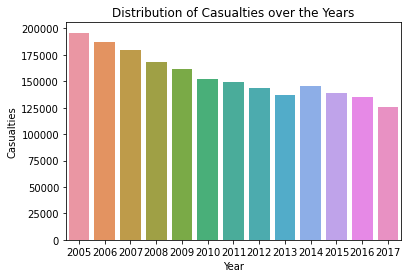

In [16]:
sns.barplot(x="Year", y="Casualties", data=df_final)
plt.title("Distribution of Casualties over the Years")
plt.show()

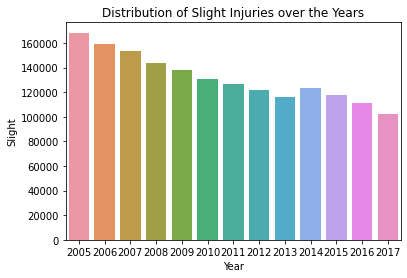

In [17]:
sns.barplot(x="Year", y="Slight", data=df_final)
plt.title("Distribution of Slight Injuries over the Years")
plt.show()

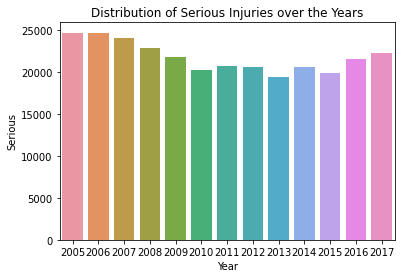

In [18]:
sns.barplot(x="Year", y="Serious", data=df_final)
plt.title("Distribution of Serious Injuries over the Years")
plt.show()

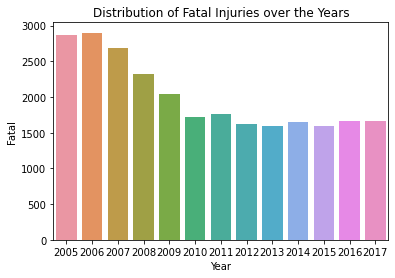

In [19]:
sns.barplot(x="Year", y="Fatal", data=df_final)
plt.title("Distribution of Fatal Injuries over the Years")
plt.show()

<AxesSubplot:xlabel='Year'>

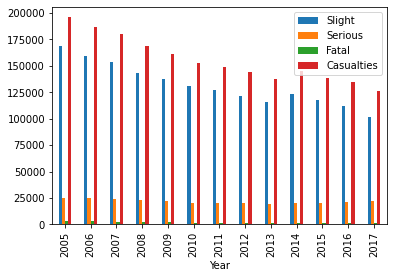

In [20]:
df_final.plot(x="Year", y=["Slight", "Serious", "Fatal", 'Casualties'], kind="bar")

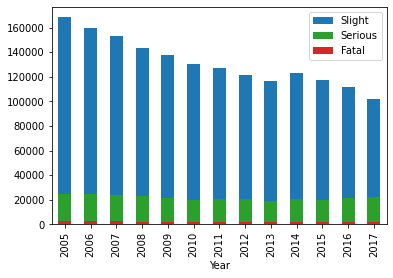

In [21]:
ax = df_final.plot(x="Year", y="Slight", kind="bar")
df_final.plot(x="Year", y="Serious", kind="bar", ax=ax, color="C2")
df_final.plot(x="Year", y="Fatal", kind="bar", ax=ax, color="C3")
# df_final.plot(x="Year", y="Casualties", kind="bar", ax=ax, color="C4")

plt.show()

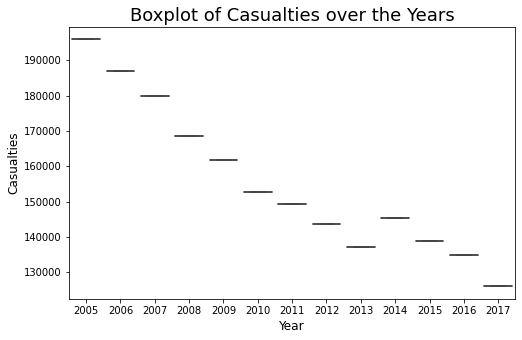

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(x = 'Year', y = 'Casualties', data = df_final)
plt.ylabel('Casualties', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Boxplot of Casualties over the Years', fontsize = 18)
plt.show()

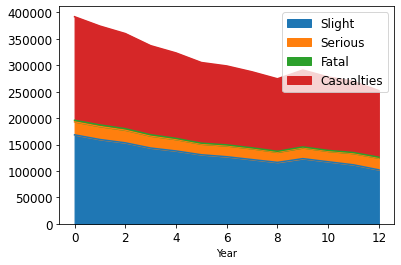

In [23]:
df_final = df_final.filter(['Slight', 'Serious', 'Fatal', 'Casualties'], axis=1)
ax = df_final.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Year');
ax.legend(fontsize=12);

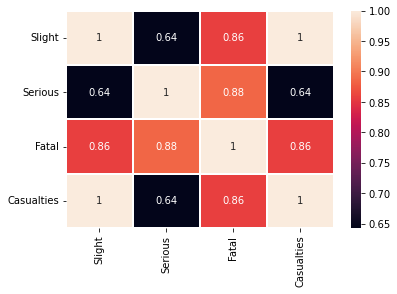

In [24]:
corr_df_final = df_final.corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix
sns.heatmap(corr_df_final,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10});

plt.xticks(rotation=90);
plt.yticks(rotation=0);